In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
from joblib import load, dump
from copy import deepcopy
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from collections import Counter

In [2]:
df = pd.read_csv('./data/features.csv')

In [3]:
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc
0,Accucheck,Fast and accurate delivery,0,4,0.232859,0.30000,0.616667,0.005420,1.0,0.0000
1,Accucheck,As usual it is genuine,0,5,0.000000,0.07500,0.375000,0.006775,1.0,0.0000
2,Accucheck,Behavior of delivery boy is very bad Delivery ...,0,20,0.552648,-0.14625,0.535417,0.025745,1.0,-0.2247
3,Accucheck,These strips were as per my requirement,0,7,1.000000,0.00000,0.000000,0.009485,0.0,0.0000
4,Accucheck,Fast service was good,0,4,0.373709,0.45000,0.600000,0.005420,1.0,0.4404
...,...,...,...,...,...,...,...,...,...,...
1650,Accucheck,Willingness to help,1,3,0.529165,0.00000,0.000000,0.004065,0.0,0.5859
1651,Accucheck,I like,0,2,0.000000,0.00000,0.000000,0.002710,0.0,0.3612
1652,Accucheck,Nice price with long expire,0,5,0.450762,0.27500,0.700000,0.006775,1.0,0.4215
1653,Accucheck,Price & Service,0,3,0.000000,0.00000,0.000000,0.004065,1.0,0.0000


### Ranking is a canonical problem for humans. It is easy to classify whether a review is useful (informative) or not. However, ranking reviews on the basis of usefulness, is a complex task. Our ranking methodology is based on this simple education.

#### Pairwise ranking approach is applied to rank reviews in the semi-supervised learning method. The pairwise ranking approach looks at a pair of documents at a time in a loss function and predicts a relative ordering. The objective is not to determine the relevance score but to find which document is more relevant than others. This relevance is developed to judge the preference of one review over another.
#### In the semi-supervised learning method, mapping is constructed between input and output. This input-output pair in the training model is used to learn the system.
#### Review Segregation: We segregated two sets of reviews on which we train our model.
+ Set 0 represents reviews with label 0, i.e., ones that are not informative. These include reviews based on delivery, customer support, packaging, etc. These reviews do not describe the product.
+ Set 1 represents reviews with label 1, i.e., reviews that are informative and are better than all reviews of Set 0;
#### How we segregated and determined labels for reviews:
### `Our entire review ranking system is based on the idea that it is easier for humans to binary classify reviews which we call Set 0 and Set 1.`

For each product 'Accucheck', 'Becadexamin', 'Evion', 'Neurobion','SevenseascodLiverOil', 'Shelcal', 'Supradyn','shampoo', we asked 10 different people to label reviews as a 1 (informative review) and 0 ( not informative review). Different participants were asked to label so that there is no bias and the model learns to its best.

In [4]:
prod = pd.crosstab(df['product'], df['label'])
prod

label,0,1
product,,
Accucheck,310,85
Becadexamin,53,27
Evion,89,33
Neurobion,280,136
SevenseascodLiverOil,59,22
Shelcal,259,124
Supradyn,50,23
shampoo,56,49


We pairwise compare each review from Set0  to Set1 and then vice versa
* (Rx, Ry, 1) where x ∈ set1 and y ∈ set0 -> Rx is better than Ry
* (Ry, Rx, 0) where y ∈ set1 and x ∈ set0 -> Ry is worse than Rx

This now becomes a classification problem

![classification](./images/classification.jpg)

In [5]:
def building_training_data(df):
    A = df[df['label']==1]
    A.loc[df['label']==1,'join'] = 'j'
    B = df[df['label']==0]
    B.loc[df['label']==0,'join'] = 'j'
    trainset1 = pd.merge(A,B,how='outer',on='join')
    trainset2 = pd.merge(B,A,how='outer',on ='join')

    trainset = pd.merge(trainset1,trainset2,how='outer')
    return trainset

In [6]:
product_list = df['product'].unique()
data_stack = []
for product in product_list:
    temp = deepcopy(df[df['product']==product].iloc[:,2:])
    build_data = building_training_data(temp)
    print(product, len(temp), len(build_data))
    build_data.drop(columns = ['join','label_y'],inplace=True)
    data = build_data.iloc[:,1:]
    data['target'] = build_data.iloc[:,0]
    data_stack.append(data)

Accucheck 395 52700
shampoo 105 5488
Becadexamin 80 2862
Neurobion 416 76160
Shelcal 383 64232
Supradyn 73 2300
SevenseascodLiverOil 81 2596
Evion 122 5874


In [7]:
train = pd.concat(data_stack).reset_index(drop=True)

In [8]:
train

,review_len_x,Rn_x,Rp_x,Rs_x,Rc_x,Rd_x,Rsc_x,review_len_y,Rn_y,Rp_y,Rs_y,Rc_y,Rd_y,Rsc_y,target
0,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,4,0.232859,0.30000,0.616667,0.005420,1.0,0.0000,1
1,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,5,0.000000,0.07500,0.375000,0.006775,1.0,0.0000,1
2,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,20,0.552648,-0.14625,0.535417,0.025745,1.0,-0.2247,1
3,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,7,1.000000,0.00000,0.000000,0.009485,0.0,0.0000,1
4,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,4,0.373709,0.45000,0.600000,0.005420,1.0,0.4404,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212207,4,0.481447,0.000000,0.0,0.010390,1.0,0.0000,7,0.720210,1.00000,0.300000,0.018182,0.0,0.6369,0
212208,4,0.481447,0.000000,0.0,0.010390,1.0,0.0000,6,0.000000,0.65000,0.390000,0.012987,0.0,0.7496,0
212209,4,0.481447,0.000000,0.0,0.010390,1.0,0.0000,12,0.522877,0.60000,0.800000,0.031169,0.0,-0.0516,0
212210,4,0.481447,0.000000,0.0,0.010390,1.0,0.0000,22,0.315448,0.02500,0.250000,0.057143,0.0,0.2960,0


In [9]:
X = train.drop(columns=['target'], axis=1)
y = train['target']

In [10]:
X

,review_len_x,Rn_x,Rp_x,Rs_x,Rc_x,Rd_x,Rsc_x,review_len_y,Rn_y,Rp_y,Rs_y,Rc_y,Rd_y,Rsc_y
0,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,4,0.232859,0.30000,0.616667,0.005420,1.0,0.0000
1,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,5,0.000000,0.07500,0.375000,0.006775,1.0,0.0000
2,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,20,0.552648,-0.14625,0.535417,0.025745,1.0,-0.2247
3,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,7,1.000000,0.00000,0.000000,0.009485,0.0,0.0000
4,7,0.133306,-0.133333,0.6,0.009485,0.0,0.4019,4,0.373709,0.45000,0.600000,0.005420,1.0,0.4404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212207,4,0.481447,0.000000,0.0,0.010390,1.0,0.0000,7,0.720210,1.00000,0.300000,0.018182,0.0,0.6369
212208,4,0.481447,0.000000,0.0,0.010390,1.0,0.0000,6,0.000000,0.65000,0.390000,0.012987,0.0,0.7496
212209,4,0.481447,0.000000,0.0,0.010390,1.0,0.0000,12,0.522877,0.60000,0.800000,0.031169,0.0,-0.0516
212210,4,0.481447,0.000000,0.0,0.010390,1.0,0.0000,22,0.315448,0.02500,0.250000,0.057143,0.0,0.2960


In [11]:
y

0         1
1         1
2         1
3         1
4         1
         ..
212207    0
212208    0
212209    0
212210    0
212211    0
Name: target, Length: 212212, dtype: int64

In [12]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42)

In [13]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((42443, 14), (42443,), (169769, 14), (169769,))

## Models
* Linear model
* Non Linear model
* Ensemble Model

## Linear Model: Logistic Regression

In [14]:
# instantiate and fit model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [15]:
# evaluate the model on the train and test
logreg.score(X_train, y_train)

0.8507560273076946

In [16]:
logreg.score(X_test, y_test)

0.8516363122305209

In [17]:
# accuracy scores of train and test
y_preds_test = logreg.predict(X_test)
y_preds_train = logreg.predict(X_train)

In [18]:
print('training accuracy score: ', accuracy_score(y_train, y_preds_train))
print('testing accuracy score: ', accuracy_score(y_test, y_preds_test))

training accuracy score:  0.8507560273076946
testing accuracy score:  0.8516363122305209


In [19]:
# classification report
print(classification_report(y_test, y_preds_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85     21222
           1       0.85      0.85      0.85     21221

    accuracy                           0.85     42443
   macro avg       0.85      0.85      0.85     42443
weighted avg       0.85      0.85      0.85     42443



**Accuracy: 85%**

**F1-Score: 85%**

## Non-Linear Model: Decision Tree

In [20]:
# instantiate and fit model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [21]:
# evaluate the model
# accuracy scores of train and test
y_preds_test = dt.predict(X_test)
y_preds_train = dt.predict(X_train)

In [22]:
print('training accuracy score: ', accuracy_score(y_train, y_preds_train))
print('testing accuracy score: ', accuracy_score(y_test, y_preds_test))

training accuracy score:  0.9964422244343785
testing accuracy score:  0.9844261715712839


In [23]:
# classification report
print(classification_report(y_test, y_preds_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     21222
           1       0.99      0.98      0.98     21221

    accuracy                           0.98     42443
   macro avg       0.98      0.98      0.98     42443
weighted avg       0.98      0.98      0.98     42443



**Accuracy Score: 98%**

**F1-Score: 98%**

The Decision Tree Classifier model does better than the linear Logistic Regression model

## Ensemble Model: Random Forest

In [29]:
# instantiate and fit the model
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True, random_state=42) # oob - out of bag error score
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=42)

In [30]:
# evaluate the models
# accuracy scores of train and test
y_preds_test = rf.predict(X_test)
y_preds_train = rf.predict(X_train)

In [31]:
print('training accuracy score: ', accuracy_score(y_train, y_preds_train))
print('testing accuracy score: ', accuracy_score(y_test, y_preds_test))

training accuracy score:  0.9964422244343785
testing accuracy score:  0.9898923261786395


In [32]:
# classification report
print(classification_report(y_test, y_preds_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     21222
           1       0.99      0.99      0.99     21221

    accuracy                           0.99     42443
   macro avg       0.99      0.99      0.99     42443
weighted avg       0.99      0.99      0.99     42443



**Accuracy: 99%**

**F1-Score: 99%**

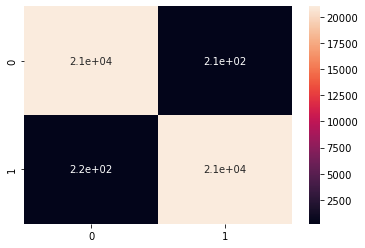

In [38]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, y_preds_test), annot=True);

In [40]:
confusion_matrix(y_test, y_preds_test)

array([[21015,   207],
       [  222, 20999]])

In [42]:
## Score of the training dataset obtained using an out-of-bag estimate. This attribute exists only when oob_score is True.
rf.oob_score_

0.9882840801324152

In [45]:
rf.feature_importances_

array([0.11734176, 0.03956505, 0.02783466, 0.01983502, 0.06511671,
       0.19101175, 0.04110883, 0.09898517, 0.03736597, 0.02421596,
       0.01966024, 0.08412011, 0.19302828, 0.04081052])

In [44]:
pd.DataFrame(rf.feature_importances_, 
            index=train.iloc[:, :-1].columns,
            columns=['importance']).sort_values('importance', ascending=False)

,importance
Rd_y,0.193028
Rd_x,0.191012
review_len_x,0.117342
review_len_y,0.098985
Rc_y,0.084120
Rc_x,0.065117
Rsc_x,0.041109
Rsc_y,0.040811
Rn_x,0.039565
Rn_y,0.037366


In [46]:
dump(rf, 'random-forest.joblib', compress=2)

['random-forest.joblib']

<hr>

## PART 2. Model Ranking Metric

### Accuracy of Ranking Methodology
+ After sorting the reviews by the review score, we wanted all reviews in Set 1 to be above all reviews of Set 0.
+ To test this hypothesis, we developed the following Ranking Metric
+ Let the number of 1s in our Dataset be x.
### `Ranking Accuracy on Single Product = Number of 1s found in first x positions / x`

In [47]:
model = load('random-forest.joblib')

In [48]:
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc
0,Accucheck,Fast and accurate delivery,0,4,0.232859,0.30000,0.616667,0.005420,1.0,0.0000
1,Accucheck,As usual it is genuine,0,5,0.000000,0.07500,0.375000,0.006775,1.0,0.0000
2,Accucheck,Behavior of delivery boy is very bad Delivery ...,0,20,0.552648,-0.14625,0.535417,0.025745,1.0,-0.2247
3,Accucheck,These strips were as per my requirement,0,7,1.000000,0.00000,0.000000,0.009485,0.0,0.0000
4,Accucheck,Fast service was good,0,4,0.373709,0.45000,0.600000,0.005420,1.0,0.4404
...,...,...,...,...,...,...,...,...,...,...
1650,Accucheck,Willingness to help,1,3,0.529165,0.00000,0.000000,0.004065,0.0,0.5859
1651,Accucheck,I like,0,2,0.000000,0.00000,0.000000,0.002710,0.0,0.3612
1652,Accucheck,Nice price with long expire,0,5,0.450762,0.27500,0.700000,0.006775,1.0,0.4215
1653,Accucheck,Price & Service,0,3,0.000000,0.00000,0.000000,0.004065,1.0,0.0000


In [49]:
product_list = df['product'].unique()
df['win'] = 0
df['lose'] = 0
df['review_score'] = 0.0
df.reset_index(inplace=True, drop=True)

In [52]:
def get_score(A,B):
    C = pd.merge(A,B, how='outer', on='j')
    C.drop(columns=['j'], inplace=True)
    i = model.predict(C.values)
    return Counter(i)

for product in product_list:
    data = df[df['product']==product]
    for indx in data.index:
        review = df.iloc[indx, 3:-3]
        review['j'] = 'jn'
        A = pd.DataFrame([review])
        B = data[data.index!=indx].iloc[:,3:-3]
        B['j'] = 'jn'
        score = get_score(A, B)
        df.at[indx, 'win'] = 0 if score.get(1) is None else score.get(1)
        df.at[indx, 'lose'] = 0 if score.get(0) is None else score.get(0)
        df.at[indx, 'review_score'] = float(0 if score.get(1) is None else score.get(1)) / len(data) * 1.0

df = df.sort_values(by = ['product','review_score'], ascending = False)

r_accuracy =[]
for product in product_list:
    x = prod[prod.index == product][1][0]
    number_of_1_in_x = Counter(df[df['product']==product].iloc[:x, ]['label']).get(1)
    rank_accuracy = float(number_of_1_in_x*1.0 / x*1.0)
    print("Product: {} | Rank Accuracy: {}".format(product, rank_accuracy))
    r_accuracy.append(rank_accuracy)
print("Mean Rank Accuracy: {}".format(mean(r_accuracy)))
    

Product: Accucheck | Rank Accuracy: 0.18823529411764706
Product: shampoo | Rank Accuracy: 0.5306122448979592
Product: Becadexamin | Rank Accuracy: 0.37037037037037035
Product: Neurobion | Rank Accuracy: 0.2647058823529412
Product: Shelcal | Rank Accuracy: 0.3790322580645161
Product: Supradyn | Rank Accuracy: 0.5652173913043478
Product: SevenseascodLiverOil | Rank Accuracy: 0.4090909090909091
Product: Evion | Rank Accuracy: 0.24242424242424243
Mean Rank Accuracy: 0.36871107407786663


In [53]:
df

,product,answer_option,label,review_len,Rn,Rp,Rs,Rc,Rd,Rsc,win,lose,review_score
178,shampoo,No solution my hair iam sorry no less of dandruff,1,10,0.476145,-0.208333,0.533333,0.023866,0.0,-0.5365,104,0,0.990476
105,shampoo,Best in hair scalp problem just wash,1,7,0.571368,1.000000,0.300000,0.016706,0.0,0.3612,102,2,0.971429
108,shampoo,We are using regularly,0,4,0.000000,0.000000,0.076923,0.009547,0.0,0.0000,98,6,0.933333
111,shampoo,The delivery person was lazy,0,5,0.621141,-0.250000,1.000000,0.011933,1.0,-0.3612,98,6,0.933333
188,shampoo,My hair getting dry after using it . It has si...,1,21,0.656563,-0.066667,0.600000,0.050119,0.0,0.0000,96,8,0.914286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,Accucheck,I like,0,2,0.000000,0.000000,0.000000,0.002710,0.0,0.3612,0,394,0.000000
1654,Accucheck,Good discount,0,2,0.631155,0.700000,0.600000,0.002710,1.0,0.4404,0,394,0.000000
1652,Accucheck,Nice price with long expire,0,5,0.450762,0.275000,0.700000,0.006775,1.0,0.4215,0,394,0.000000
1653,Accucheck,Price & Service,0,3,0.000000,0.000000,0.000000,0.004065,1.0,0.0000,0,394,0.000000


In [54]:
df.iloc[:, [0,1,-1]].to_csv('./data/train_ranked.csv', index=False)